## Extractive Text Summarization with Seq2Seq model  
Develop a basic character-level seq2seq model for text summarization. Use a word-level model, which is quite common in the domain of text processing. For this article, use character level models. As mentioned earlier, encoder and decoder architecture is a way of creating RNNs for sequence prediction. Encoders read the entire input sequence and encode it into an internal representation, usually, a fixed-length vector named the context vector. The decoder, on the other hand, reads the encoded input sequence from the encoder and produces the output sequence.

The encoder-decoder architecture consists of two primary models: one reads the input sequence and encodes it to a fixed-length vector, and the second decodes the fixed-length vector and outputs the predicted sequence. This architecture is designed for seq2seq problems.

the data source for this excercise is from [kaggle](https://www.kaggle.com/sunnysai12345/news-summary)

In [56]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup

import spacy
from time import time

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Tokenize the text to get the vocab count 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [57]:
#####--- TO run on all reviews remove nrows=2000 ---#####
raw = pd.read_csv('data/news_summary.csv', encoding='iso-8859-1', nrows=6000)

In [58]:
df = raw[['ctext', 'headlines']]
df.columns = ['text', 'summary']

In [59]:
df.head()

,text,summary
0,The Daman and Diu administration on Wednesday ...,Daman & Diu revokes mandatory Rakshabandhan in...
1,"From her special numbers to TV?appearances, Bo...",Malaika slams user who trolled her for 'divorc...
2,The Indira Gandhi Institute of Medical Science...,'Virgin' now corrected to 'Unmarried' in IGIMS...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Aaj aapne pakad liya: LeT man Dujana before be...
4,Hotels in Mumbai and other Indian cities are t...,Hotel staff to get training to spot signs of s...


In [65]:
df.dropna(inplace=True)

### Cleaning the Data  
The data you procured can have non-alphabetic characters which you can remove before training the model. To do this, you can use the re (Regular Expressions) library

In [60]:
# Remove non-alphabetic characters (Data Cleaning)

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

def text_strip(text):
    """ Clean review data"""

    text = re.sub("(\\t)", " ", str(text))
    text = re.sub("(\\r)", " ", str(text))
    text = re.sub("(\\n)", " ", str(text))
        
        # remove html tags
    text = strip_html_tags(text)
        
        # remove URL from text
    text = re.sub(r"http\S+", "", text)        
        
        # Remove _ if it occurs more than one time consecutively
    text = re.sub("(__+)", " ", str(text))

        # Remove - if it occurs more than one time consecutively
    text = re.sub("(--+)", " ", str(text))

        # Remove ~ if it occurs more than one time consecutively
    text = re.sub("(~~+)", " ", str(text))

        # Remove + if it occurs more than one time consecutively
    text = re.sub("(\+\++)", " ", str(text))

        # Remove . if it occurs more than one time consecutively
    text = re.sub("(\.\.+)", " ", str(text))

    # Remove the characters - <>()|&©ø"',;?~*!
    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", " ", str(text))

    # Remove mailto:
    text = re.sub("(mailto:)", " ", str(text))

    # Remove \x9* in text
    text = re.sub(r"(\\x9\d)", " ", str(text))

    # Replace INC nums to INC_NUM
    text = re.sub("([iI][nN][cC]\d+)", "INC_NUM", str(text))

    # Replace CM# and CHG# to CM_NUM
    text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", "CM_NUM", str(text))

        # Remove punctuations at the end of a word
    text = re.sub("(\.\s+)", " ", str(text))
    text = re.sub("(\-\s+)", " ", str(text))
    text = re.sub("(\:\s+)", " ", str(text))

    # Replace any url to only the domain name
    try:
        url = re.search(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", str(text))
        repl_url = url.group(3)
        text = re.sub(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", repl_url, str(text))
    except:
        pass

    # Remove multiple spaces
    text = re.sub("(\s+)", " ", str(text))

    # Remove the single character hanging between any two spaces
    text = re.sub("(\s+.\s+)", " ", str(text)).lower()

    return text

In [67]:
df['cleaned_text'] = df['text'].apply(lambda x: text_strip(x))
df['cleaned_summary'] = df['summary'].apply(lambda x: text_strip(x))

The _START_ and _END_ tokens denote the start and end of the summary, respectively. This will be used later to detect and remove empty summaries.

In [68]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) 

# Process text as batches and yield Doc objects in order
processed_text = df['cleaned_text'].to_list()
text = [str(doc) for doc in nlp.pipe(processed_text, batch_size=500)]

processed_summary = df['cleaned_summary'].to_list()
summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(processed_summary, batch_size=500)]

In [69]:
len(text), len(summary)

(4396, 4396)

In [70]:
text[0]

'the daman and diu administration on wednesday withdrew circular that asked women staff to tie rakhis on male colleagues after the order triggered backlash from employees and was ripped apart on social media.the union territory administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate rakshabandhan at workplace it has been decided to celebrate the festival of rakshabandhan on august in this connection all offices/ departments shall remain open and celebrate the festival collectively at suitable time wherein all the lady staff shall tie rakhis to their colleagues the order issued on august by gurpreet singh deputy secretary personnel had said.to ensure that no one skipped office an attendance report was to be sent to the government the next evening.the two notifications one mandating the celebration of rakshabandhan left and the other withdrawing the mandate right were issued by the daman and diu administration day ap

In [71]:
summary[0]

'_START_ daman diu revokes mandatory rakshabandhan in offices order _END_'

#### Determining the Maximum Sequence Lengths  
Plot a graph to determine the frequency ranges tied to the lengths of text and summary, i.e., determine the range of length of words where the maximum number of texts and summaries fall into.  

From the graphs, you can determine the range where the maximum number of words fall into. For summary, you can assign the range to be 0-15.
To find the range of text which we aren't able to clearly decipher from the graph, consider a random range and find the percentage of words falling into that range.

In [72]:
df.head()

,text,summary,cleaned_text,cleaned_summary
0,The Daman and Diu administration on Wednesday ...,Daman & Diu revokes mandatory Rakshabandhan in...,the daman and diu administration on wednesday ...,daman diu revokes mandatory rakshabandhan in o...
1,"From her special numbers to TV?appearances, Bo...",Malaika slams user who trolled her for 'divorc...,from her special numbers to tv appearances bol...,malaika slams user who trolled her for divorci...
2,The Indira Gandhi Institute of Medical Science...,'Virgin' now corrected to 'Unmarried' in IGIMS...,the indira gandhi institute of medical science...,virgin now corrected to unmarried in igims form
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Aaj aapne pakad liya: LeT man Dujana before be...,lashkar-e-taiba kashmir commander abu dujana w...,aaj aapne pakad liya let man dujana before bei...
4,Hotels in Mumbai and other Indian cities are t...,Hotel staff to get training to spot signs of s...,hotels in mumbai and other indian cities are t...,hotel staff to get training to spot signs of s...


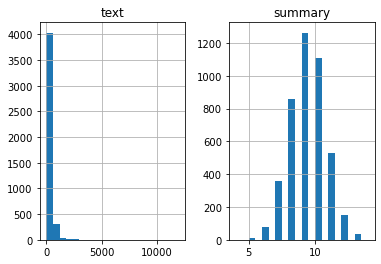

In [73]:
text_count = []
summary_count = []

for sent in df['cleaned_text']:
    text_count.append(len(sent.split()))
    
for sent in df['cleaned_summary']:
    summary_count.append(len(sent.split()))

graph_df = pd.DataFrame() 

graph_df['text'] = text_count
graph_df['summary'] = summary_count

graph_df.hist(bins = 20)
plt.show()

In [74]:
# Check how much % of text have 0-100 words
cnt = 0
for i in df['cleaned_text']:
    if len(i.split()) <= 500:
        cnt = cnt + 1
print(cnt / len(df['cleaned_text']))

0.8591901728844404


In [75]:
# Model to summarize the text between 0-15 words for Summary and 0-100 words for Text
max_text_len = 500
max_summary_len = 15

In [76]:
# Select the Summaries and Text which fall below max length for both
import numpy as np

cleaned_text = np.array(df['cleaned_text'])
cleaned_summary= np.array(df['cleaned_summary'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_text[i].split()) <= max_text_len:
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_df = pd.DataFrame({'text': short_text,'summary': short_summary})

In [77]:
post_df.head()

,text,summary
0,the daman and diu administration on wednesday ...,daman diu revokes mandatory rakshabandhan in o...
1,from her special numbers to tv appearances bol...,malaika slams user who trolled her for divorci...
2,the indira gandhi institute of medical science...,virgin now corrected to unmarried in igims form
3,lashkar-e-taiba kashmir commander abu dujana w...,aaj aapne pakad liya let man dujana before bei...
4,an alleged suspect in kidnapping case was foun...,man found dead at delhi police station kin all...


Now add start of the sequence (sostok) and end of the sequence (eostok) to denote start and end of the summaries, respectively. This shall be useful to trigger the start of summarization during the inferencing phase.

In [78]:
# Add sostok and eostok
post_df['summary'] = post_df['summary'].apply(lambda x: 'sostok ' + x + ' eostok')
post_df.head()

,text,summary
0,the daman and diu administration on wednesday ...,sostok daman diu revokes mandatory rakshabandh...
1,from her special numbers to tv appearances bol...,sostok malaika slams user who trolled her for ...
2,the indira gandhi institute of medical science...,sostok virgin now corrected to unmarried in i...
3,lashkar-e-taiba kashmir commander abu dujana w...,sostok aaj aapne pakad liya let man dujana bef...
4,an alleged suspect in kidnapping case was foun...,sostok man found dead at delhi police station ...


#### Tokenizing the Text
First split the data into train and test data chunks.

In [79]:
x_train, x_val, y_train, y_val = train_test_split(
    np.array(post_df["text"]),
    np.array(post_df["summary"]),
    test_size=0.1,
    random_state=0,
    shuffle=True,
)

In [80]:
# Prepare a tokenizer on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_train))

In [81]:
# Find the percentage of occurrence of rare words (say, occurring less than 5 times) in the text.
thresh = 5

cnt = 0
tot_cnt = 0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary: ", (cnt / tot_cnt) * 100)

% of rare words in vocabulary:  67.8346090194456


Tokenize the text again by considering the total number of words minus the rare occurrences. Convert text to numbers and pad them all to the same length.

In [82]:
# Prepare a tokenizer, again -- by not considering the rare words
x_tokenizer = Tokenizer(num_words = tot_cnt - cnt) 
x_tokenizer.fit_on_texts(list(x_train))

# Convert text sequences to integer sequences 
x_tr_seq = x_tokenizer.texts_to_sequences(x_train) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# Pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

# Size of vocabulary (+1 for padding token)
#x_vocab_size = x_tokenizer.num_words + 1
x_vocab_size = len(x_tokenizer.word_index) + 1


print("Size of vocabulary in X = {}".format(x_vocab_size))

Size of vocabulary in X = 38673


In [83]:
# Prepare a tokenizer on testing data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_train))

thresh = 5

cnt = 0
tot_cnt = 0

for key, value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary:",(cnt / tot_cnt) * 100)

% of rare words in vocabulary: 82.64140803439474


In [84]:
# Prepare a tokenizer, again -- by not considering the rare words
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_train))

# Convert text sequences to integer sequences 
y_tr_seq = y_tokenizer.texts_to_sequences(y_train) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 

# Pad zero upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

# Size of vocabulary (+1 for padding token)
#y_vocab_size = y_tokenizer.num_words + 1
y_vocab_size = len(y_tokenizer.word_index) + 1

print("Size of vocabulary in Y = {}".format(y_vocab_size))

Size of vocabulary in Y = 7444


#### Removing Empty Texts and Summaries
Remove all empty summaries (which only have START and END tokens) and their associated texts from the data.

In [85]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
ind = []
for i in range(len(y_tr)):
    cnt = 0
    for j in y_tr[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_tr = np.delete(y_tr, ind, axis=0)
x_tr = np.delete(x_tr, ind, axis=0)

In [86]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
ind = []
for i in range(len(y_val)):
    cnt = 0
    for j in y_val[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_val = np.delete(y_val, ind, axis=0)
x_val = np.delete(x_val, ind, axis=0)

## Seq2Seq Model

In [87]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [88]:
latent_dim = 300
embedding_dim = 100

### Use GloVe embedding

In [89]:
glove_file = '/Users/ndah/Desktop/NLP/glove/glove.6B.100d.txt'
glove_embeddings=open(glove_file, encoding="utf8")

In [90]:
embedding_dict=dict()

for embeddings in glove_embeddings:
    embedding_tokens = embeddings.split()
    emb_word = embedding_tokens[0]
    emb_vector = np.asarray(embedding_tokens[1:], dtype='float32')
    embedding_dict[emb_word] = emb_vector

glove_embeddings.close()

In [91]:
# X_embedding
X_embedding_mat= np.zeros((x_vocab_size, embedding_dim))
for word, index in x_tokenizer.word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        X_embedding_mat[index] = embedding_vector

In [92]:
Y_embedding_mat= np.zeros((y_vocab_size, embedding_dim))
for word, index in y_tokenizer.word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        Y_embedding_mat[index] = embedding_vector

#### Encoder
The input length that the encoder accepts is equal to the maximum text length. This is then given to an Embedding Layer of dimension (total number of words captured in the text vocabulary) x (number of nodes in an embedding layer). This is followed by three LSTM networks wherein each layer returns the LSTM output, as well as the hidden and cell states observed at the previous time steps.  

In [93]:
# Encoder
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding layer
#enc_emb = Embedding(x_vocab_size, embedding_dim, trainable=True)(encoder_inputs)
enc_emb = Embedding(x_vocab_size, embedding_dim, weights=[X_embedding_mat], trainable=False)(encoder_inputs)


# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

#### Decoder

In the decoder, an embedding layer is defined followed by an LSTM network. The initial state of the LSTM network is the last hidden and cell states taken from the encoder. The output of the LSTM is given to a Dense layer wrapped in a TimeDistributed layer with an attached softmax activation function. Altogether, the model accepts encoder (text) and decoder (summary) as input and it outputs the summary. The prediction happens through predicting the upcoming word of the summary from the previous word of the summary

In [94]:
# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
#dec_emb_layer = Embedding(y_vocab_size, embedding_dim, trainable=True)
dec_emb_layer = Embedding(y_vocab_size, embedding_dim, weights=[Y_embedding_mat], trainable=False)

dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

In [95]:
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 500, 100)     3867300     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 500, 300),   481200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

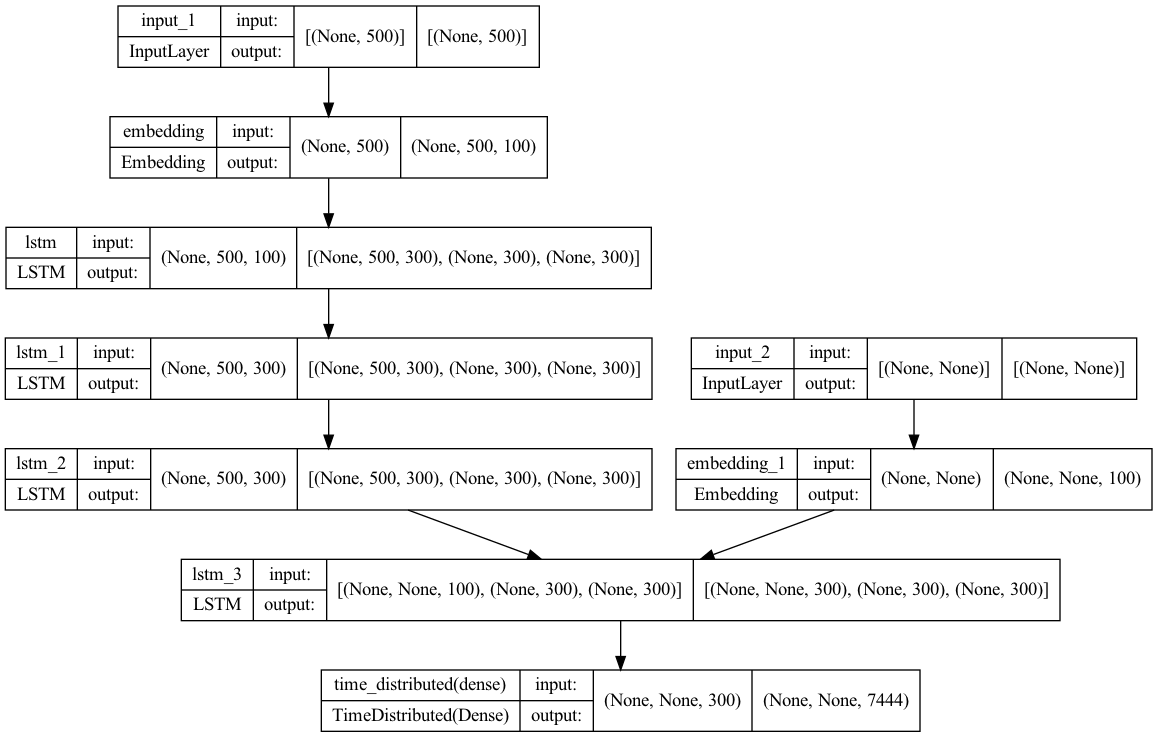

In [96]:
plot_model(model, show_shapes=True, show_layer_names=True)

### Training the Model  
First compile the model and define EarlyStopping to stop training the model once the validation loss metric has stopped decreasing.  

Next, use the model.fit() method to fit the training data where you can define the batch size to be 128. Send the text and summary (excluding the last word in summary) as the input, and a reshaped summary tensor comprising every word (starting from the second word) as the output (which explains the infusion of intelligence into the model to predict a word, given the previous word). Besides, to enable validation during the training phase, send the validation data as well.

In [97]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [98]:
# with tf.device('/gpu:0'):
#     history = model.fit(
#         [x_tr, y_tr[:, :-1]],
#         y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
#         epochs=5,
#         callbacks=[es],
#         batch_size=128,
#         validation_data=([x_val, y_val[:, :-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:]),
#     )

In [99]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=1,
    callbacks=[es],
    batch_size=128,
    validation_data=([x_val, y_val[:, :-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:]),
    )

 7/27 [======>.......................] - ETA: 37:27:20 - loss: 6.3882

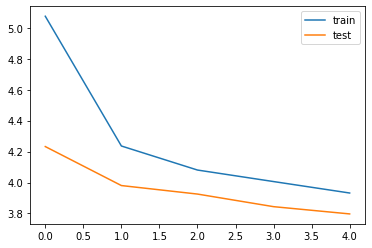

In [ ]:
## plot the training and validation loss metrics observed during the training phase.
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Generating Predictions
To generate summaries from the given pieces of text, first reverse map the indices to the words. 
Map the words to indices from the summaries tokenizer which is to be used to detect the start and end of the sequences.

In [ ]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

An encoder inference model accepts text and returns the output generated from the three LSTMs, and hidden and cell states. A decoder inference model accepts the start of the sequence identifier (sostok) and predicts the upcoming word, eventually leading to predicting the whole summary.

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

In [ ]:
# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2, 
                                                      initial_state=[decoder_state_input_h,
                                                                     decoder_state_input_c]
                                                     )

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
# To convert sequence to summary
def seq2summary(input_seq):
    new_string = []
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i \
            != target_word_index['eostok']:
            new_string.append(reverse_target_word_index[i])
            
    return  ' '.join(new_string[1:-1])


# To convert sequence to text
def seq2text(input_seq):
    new_string = ''
    for i in input_seq:
        if i != 0:
            new_string = new_string + reverse_source_word_index[i] + ' '

    return new_string


def decode_sequence(input_seq):
    """Generating words until eostok is encountered or the maximum length"""

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = []

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eostok':
            decoded_sentence.append(sampled_token)

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'eostok' or len(decoded_sentence) >= max_summary_len - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return ' '.join(decoded_sentence[1:-1])

In [ ]:
# generate the predictions by sending in the text
for i in range(15, 19):
    print ('Review:', seq2text(x_tr[i]))
    print ('Original summary:', seq2summary(y_tr[i]))
    print ('Predicted summary:', decode_sequence(x_tr[i].reshape(1, max_text_len)))
    print()

Review: the cbi arrested six officials and private persons in connection with case of alleged corruption in the sports authority of india sai on thursday the arrests were made during searches at sai office in delhi lodhi road bills of lakh were allegedly pending to be cleared by the officials for which demand of 3 was being made 
Original summary: cbi arrests sports of india officials in corruption case
Predicted summary: i to be be be be be

Review: reacting to wrestler photo from the royal shared by the wwe universe twitter account user tweeted when you hit just your toe against in the dark other users reacted to the image with tweets like when you realize tomorrow is monday and when your boss comes into your cube and you re on youtube 
Original summary: when you your user tweets on photo
Predicted summary: i to be be be be be

Review: the ministry of corporate affairs mca is planning to collect know your customer kyc details of companies chartered cost and company secretaries the ex

### Extractive summarization with BERT

In [ ]:
# !pip install bert-extractive-summarizer
# !pip install -U sentence-transformers -qq

In [ ]:
from summarizer import Summarizer, TransformerSummarizer

In [ ]:
bert_model = Summarizer()

Downloading: 100%|██████████| 571/571 [00:00<00:00, 298kB/s]
Downloading: 100%|██████████| 1.25G/1.25G [07:25<00:00, 3.02MB/s]
Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Downloading: 100%|█████████

In [ ]:
n = 5
text = df['text'].to_list()[n]
original_summary = df['summary'].to_list()[n]

pred_summary = bert_model(text)
print('Original text:\n', text, '\n')
print('Summary:\n', pred_summary)

Original text:
 An alleged suspect in a kidnapping case was found hanging inside the washroom of the Jahangirpuri police station in north Delhi on Wednesday, hours after he was called by the cops for interrogation.The police claimed it was an ?unprovoked suicide? and denied use of force. An internal inquiry as well as a magisterial probe is in process, police said. The relatives of the deceased suspect foul play in the death.The dead man is 32-year-old Raj Kumar. A native of Kasganj in UP, Kumar was unmarried and worked as a security guard at a government school in Pitampura till a few months ago.?During his stint at that school, he entered into a relationship with a married woman who worked as a peon. Their relationship ended a few months ago and Kumar quit the job and returned to his village,? said a police officer.The woman went missing a few months ago, prompting her husband to file a police complaint and a habeas corpus petition at the Delhi High Court.?The woman?s husband suspect

In [ ]:
gpt2_model = TransformerSummarizer(transformer_type="GPT2",transformer_model_key="gpt2-medium")


In [ ]:
pred_summary = ''.join(gpt2_model(text, min_length=60))
# print('Original text:\n', text, '\n')
print('Summary:\n', pred_summary)

Downloading: 100%|██████████| 718/718 [00:00<00:00, 254kB/s]
Downloading: 100%|██████████| 1.42G/1.42G [06:04<00:00, 4.17MB/s] 
Downloading: 100%|██████████| 0.99M/0.99M [00:00<00:00, 1.55MB/s]
Downloading: 100%|██████████| 446k/446k [00:00<00:00, 841kB/s] 
Downloading: 100%|██████████| 1.29M/1.29M [00:00<00:00, 1.88MB/s]


Original text:
 An alleged suspect in a kidnapping case was found hanging inside the washroom of the Jahangirpuri police station in north Delhi on Wednesday, hours after he was called by the cops for interrogation.The police claimed it was an ?unprovoked suicide? and denied use of force. An internal inquiry as well as a magisterial probe is in process, police said. The relatives of the deceased suspect foul play in the death.The dead man is 32-year-old Raj Kumar. A native of Kasganj in UP, Kumar was unmarried and worked as a security guard at a government school in Pitampura till a few months ago.?During his stint at that school, he entered into a relationship with a married woman who worked as a peon. Their relationship ended a few months ago and Kumar quit the job and returned to his village,? said a police officer.The woman went missing a few months ago, prompting her husband to file a police complaint and a habeas corpus petition at the Delhi High Court.?The woman?s husband suspect

##### XLNet

In [ ]:
xlnet_model = TransformerSummarizer(transformer_type="XLNet",transformer_model_key="xlnet-base-cased")

In [ ]:
pred_summary = ''.join(xlnet_model(text, min_length=60))
# print('Original text:\n', text, '\n')
print('Summary:\n', pred_summary)

### Use SBert
One can use Sentence Bert with bert-extractive-summarizer with the newest version. It is based off the paper here: https://arxiv.org/abs/1908.10084, and the library here: https://www.sbert.net/. To get started, first install SBERT:

In [ ]:
from summarizer.sbert import SBertSummarizer

In [ ]:
sbert_model = SBertSummarizer('paraphrase-MiniLM-L6-v2')

Downloading: 100%|██████████| 190/190 [00:00<00:00, 136kB/s]
Downloading: 100%|██████████| 3.69k/3.69k [00:00<00:00, 2.40MB/s]
Downloading: 100%|██████████| 229/229 [00:00<00:00, 80.9kB/s]
Downloading: 100%|██████████| 90.9M/90.9M [00:15<00:00, 6.00MB/s]
Downloading: 100%|██████████| 53.0/53.0 [00:00<00:00, 33.5kB/s]
Downloading: 100%|██████████| 112/112 [00:00<00:00, 37.1kB/s]
Downloading: 100%|██████████| 466k/466k [00:00<00:00, 856kB/s]  
Downloading: 100%|██████████| 314/314 [00:00<00:00, 177kB/s]
Downloading: 100%|██████████| 232k/232k [00:00<00:00, 571kB/s] 


In [ ]:
pred_summary = sbert_model(text, num_sentences=3) 
print('Summary:\n', pred_summary)

Summary:
 An alleged suspect in a kidnapping case was found hanging inside the washroom of the Jahangirpuri police station in north Delhi on Wednesday, hours after he was called by the cops for interrogation. The relatives of the deceased suspect foul play in the death. A team was sent to Kumar?s village but when he was found unavailable, he was instructed to report to the Jahangirpuri police station.?Kumar was confident he had no role in the woman?s disappearance.


## Assignment 2:  
Train a sequence to sequence extractive summarzation model using BERT-based word embeddings.